With Updated Data:
Morning: 
window: 10min
*35, -1.5
neighbors = 9
pred_loss = 0.10849615522538006

Night:
window: 20min
*35, -5
neighbors = 12
pred_loss = 0.151006

To do:
1. tollgate(20) abnormal data in test set
2. try wavelet denoise (yby)
3. try other metrics for distance
4. other information e.g. road network and weather
5. 

In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import math
import copy
from datetime import datetime, timedelta, date, time

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
training_traj = pd.read_csv('dataSet_phase2/trajectories(table_5)_training2.csv')
test_traj2 = pd.read_csv('dataSet_phase2/trajectories(table 5)_test2.csv')

In [3]:
training_path = 'dataSets/training/'
test_path1 = 'dataSets/testing_phase1/'

In [4]:
training_vol_old = pd.read_csv(training_path+'volume(table 6)_training.csv')
test_vol1 = pd.read_csv(test_path1+'volume(table 6)_test1.csv')

In [5]:
training_vol = pd.read_csv('dataSet_phase2/volume(table 6)_training2.csv')
test_vol2 = pd.read_csv('dataSet_phase2/volume(table 6)_test2.csv')

In [6]:
training_vol_old.columns = training_vol.columns

In [7]:
training_vol = pd.concat([training_vol_old, training_vol])

In [8]:
training_vol.head()

date_time  tollgate  direction  model  is_etc  veh_type
0  2016-09-19 23:09:25         2          0      1       0       NaN
1  2016-09-19 23:11:53         2          0      1       0       NaN
2  2016-09-19 23:13:54         2          0      1       0       NaN
3  2016-09-19 23:17:48         1          0      1       1       NaN
4  2016-09-19 23:16:07         2          0      1       0       NaN

In [9]:
def time_to_window(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    dtmin = int(dt.minute / 10) * 10
    dtwindow = datetime(dt.year, dt.month, dt.day, dt.hour, dtmin, 0)
    return dtwindow


In [10]:
def format_window(wd):
    return '[{},{})'.format(str(wd), str(wd+timedelta(minutes=10)))

In [11]:
#training_traj['starting_datetime'] = pd.to_datetime(training_path['starting_time'])
training_traj['window'] = training_traj['starting_time'].apply(time_to_window)

training_traj_group_mean = \
training_traj.groupby(['intersection_id','tollgate_id','window']).mean()['travel_time']

training_traj_group_count = \
training_traj.groupby(['intersection_id','tollgate_id','window']).count()['travel_time']

In [12]:
training_vol['window'] = training_vol['date_time'].apply(time_to_window)

training_vol_group_count = \
training_vol.groupby(['tollgate','direction','window']).count()['date_time']


In [13]:
test_vol2['window'] = test_vol2['date_time'].apply(time_to_window)

test_vol_group_count = \
test_vol2.groupby(['tollgate','direction','window']).count()['date_time']

In [14]:
sample = pd.read_csv('submission/submission_sample_volume.csv')

In [16]:
date_list2 = []

d1 = date(2016, 10, 25)  # start date
d2 = date(2016, 10, 31)  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    date_list2.append(d1 + timedelta(days=i))

In [17]:
tiid2 = ['10']*7 + ['11']*7 + ['20']*7 + ['30']*7 + ['31']*7
dlid2 = date_list2*5

In [18]:
df_morning_test = pd.DataFrame((test_vol_group_count.values).reshape(-1,12)[::2])
df_night_test = pd.DataFrame((test_vol_group_count.values).reshape(-1,12)[1::2])
df_morning_test['ti'] = tiid2
df_morning_test['dl'] = dlid2
df_night_test['ti'] = tiid2
df_night_test['dl'] = dlid2
df_morning_test['wkwn'] = [1,1,1,1,0,0,1]*5
df_morning_test['wkwn'] *= 35

df_night_test['wkwn'] = [1,1,1,1,0,0,1]*5
df_night_test['wkwn'] *= 35

In [19]:
df_morning_test

0   1   2   3   4   5   6   7   8   9  10  11  ti          dl  wkwn
0    8   2   5  12  17  13  10  15  14  24  22  22  10  2016-10-25    35
1    4   8   3   6   8  17  15  16  14  18  25  20  10  2016-10-26    35
2    9   5   7   7   8  15  13   7  19  17  24  18  10  2016-10-27    35
3    3   5   8  13   9   5   9  19  12  25  23  23  10  2016-10-28    35
4    2   9   8   9   6  13  11  16  21  16  14  10  10  2016-10-29     0
5    8  10  13  12  16  14  21  28  16  24  31  43  10  2016-10-30     0
6   12  15  26  28  24  36  41  54  38  60  50  56  10  2016-10-31    35
7   20  17  19  35  36  27  33  34  50  49  67  66  11  2016-10-25    35
8   17  20  20  31  34  23  32  37  47  49  45  65  11  2016-10-26    35
9   22  15  21  25  25  26  31  31  38  56  46  58  11  2016-10-27    35
10  18  17  26  31  34  31  39  47  49  51  50  63  11  2016-10-28    35
11  16  16  19  20  34  24  26  31  36  42  45  44  11  2016-10-29     0
12  23  19  17  25  26  30  30  34  34  36  34  31  11  2016-10-30     0
13  14  22  17  28  31  42  47  41  43  56  53  62  11  2016-10-31    35
14  11  18  14  13  20  20  42  41  36  62  42  51  20  2016-10-25    35
15  12  20  13  14  16  23  25  49  47  41  54  45  20  2016-10-26    35
16  10  10  12  24  21  29  33  37  39  42  49  65  20  2016-10-27    35
17   4  15  11  12  21  32  28  38  45  54  49  48  20  2016-10-28    35
18  15   8  21  21  17  23  16  18  24  29  27  34  20  2016-10-29     0
19   2   3   1   2   4   2   2   4   9   2   8   8  20  2016-10-30     0
20   1   9   6   4   7   7  16  21  19  23  36  22  20  2016-10-31    35
21  14  14  18  30  44  48  67  62  52  79  66  73  30  2016-10-25    35
22  13  11  31  19  36  38  69  60  65  56  61  83  30  2016-10-26    35
23  15   9  15  25  35  28  62  58  55  57  69  65  30  2016-10-27    35
24  10  15  19  33  33  37  45  75  56  48  70  81  30  2016-10-28    35
25  13  14  13  25  25  34  33  32  39  39  47  45  30  2016-10-29     0
26   5  10  19  18  26  30  35  35  41  37  36  50  30  2016-10-30     0
27  14  12  26  27  37  44  74  74  83  83  71  91  30  2016-10-31    35
28  14  16  13  18  17  25  22  40  39  50  32  52  31  2016-10-25    35
29   6  15  13  23  22  19  20  30  36  46  35  51  31  2016-10-26    35
30   8  16  10  15  14  35  25  27  43  47  32  54  31  2016-10-27    35
31   7  12   6  13  23  28  14  38  22  35  37  40  31  2016-10-28    35
32   5   8  13  15  11  21  25  29  28  36  33  32  31  2016-10-29     0
33   3  18  18  16  10  15  29  31  27  32  33  27  31  2016-10-30     0
34  13   9   9  20  18  30  38  30  41  47  56  53  31  2016-10-31    35

In [20]:
date_list = []

d1 = date(2016, 9, 19)  # start date
d2 = date(2016, 10, 24)  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    date_list.append(d1 + timedelta(days=i))

give_time_list1 = [time(6,0), time(6,10), time(6,20),
                   time(6,30), time(6,40), time(6,50),
                   time(7,0), time(7,10), time(7,20),
                   time(7,30), time(7,40), time(7,50)]
pred_time_list1 = [time(8,0), time(8,10), time(8,20),
                   time(8,30), time(8,40), time(8,50),
                   time(9,0), time(9,10), time(9,20),
                   time(9,30), time(9,40), time(9,50)]

give_time_list2 = [time(15,0), time(15,10), time(15,20),
                   time(15,30), time(15,40), time(15,50),
                   time(16,0), time(16,10), time(16,20),
                   time(16,30), time(16,40), time(16,50)]
pred_time_list2 = [time(17,0), time(17,10), time(17,20),
                   time(17,30), time(17,40), time(17,50),
                   time(18,0), time(18,10), time(18,20),
                   time(18,30), time(18,40), time(18,50)]

In [21]:
def interpolate_missing_window(x):
    ss = [(i-datetime(1970,1,1)).total_seconds() for i in x.index]
    tt = x.values
    ssall = np.linspace(ss[0], ss[-1], (ss[-1]-ss[0])/1200+1)
    #print(len(ss), len(tt), len(ssall))
    ttall = np.interp(ssall, ss, tt)
    ssall = [int(i) for i in ssall]
    ssall = [datetime(1970,1,1)+timedelta(seconds=i) for i in ssall]
    return pd.Series(index=ssall, data=ttall)

In [22]:
first6 = np.array([])
next6 = np.array([])
for ti, d in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    mtmp = training_vol_group_count.loc[ti, d]
    #mtmp = interpolate_missing_window(mtmp)
    test6 = []
    for i in date_list:
        tmp = []
        for j in give_time_list1:
            try:
                tmp.append(mtmp[datetime.combine(i, j)])
            except:
                tmp.append(0)
        test6.append(tmp)
    result6 = test6
    first6 = np.append(first6, result6)
    
    test6 = []
    for i in date_list:
        tmp = []
        for j in pred_time_list1:
            try:
                tmp.append(mtmp[datetime.combine(i, j)])
            except:
                tmp.append(0)
        test6.append(tmp)
    result6 = test6
    next6 = np.append(next6, result6)

morning_volume66 = np.append(first6.reshape(-1,12), next6.reshape(-1,12), axis=1)

In [23]:
tiid = ['10']*36 + ['11']*36 + ['20']*36 + ['30']*36 + ['31']*36
dlid = date_list*5

In [24]:
first6 = np.array([])
next6 = np.array([])
for ti, d in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    mtmp = training_vol_group_count.loc[ti, d]
    #mtmp = interpolate_missing_window(mtmp)
    test6 = []
    for i in date_list:
        tmp = []
        for j in give_time_list2:
            try:
                tmp.append(mtmp[datetime.combine(i, j)])
            except:
                tmp.append(0)
        test6.append(tmp)
    result6 = test6
    first6 = np.append(first6, result6)
    
    test6 = []
    for i in date_list:
        tmp = []
        for j in pred_time_list2:
            try:
                tmp.append(mtmp[datetime.combine(i, j)])
            except:
                tmp.append(0)
        test6.append(tmp)
    result6 = test6
    next6 = np.append(next6, result6)

night_volume66 = np.append(first6.reshape(-1,12), next6.reshape(-1,12), axis=1)

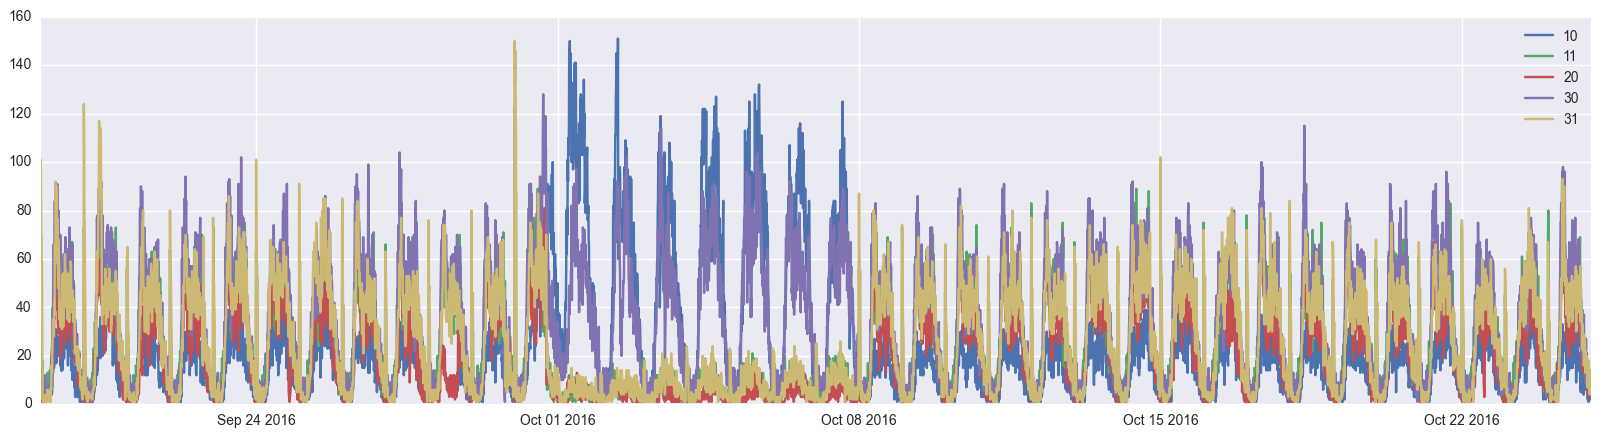

In [25]:
ttt10 = training_vol_group_count.loc[1, 0]
ttt11 = training_vol_group_count.loc[1, 1]
ttt20 = training_vol_group_count.loc[2, 0]
ttt30 = training_vol_group_count.loc[3, 0]
ttt31 = training_vol_group_count.loc[3, 1]

plt.figure(figsize=(20,5))
plt.plot(ttt10.index, ttt10)
plt.plot(ttt11.index, ttt11)
plt.plot(ttt20.index, ttt20)
plt.plot(ttt30.index, ttt30)
plt.plot(ttt31.index, ttt31)

plt.legend([10,11,20,30,31])

In [26]:
df_morning = pd.DataFrame(morning_volume66)

df_night = pd.DataFrame(night_volume66)

In [27]:
len(df_night)

180

In [28]:
df_morning['ti'] = tiid
df_morning['dl'] = dlid
df_night['ti'] = tiid
df_night['dl'] = dlid

In [29]:
df_morning.head()

0     1     2     3     4     5     6     7     8     9     ...      \
0   4.0   4.0   6.0   7.0  19.0  13.0  19.0  20.0  15.0  16.0     ...       
1   6.0   7.0  10.0  10.0   8.0  21.0  15.0  23.0  12.0  18.0     ...       
2  19.0  17.0  20.0  21.0  39.0  36.0  25.0  53.0  38.0  46.0     ...       
3   1.0   5.0   3.0   7.0  19.0  17.0  14.0  14.0  18.0  22.0     ...       
4   2.0  10.0   7.0  10.0  15.0  17.0  15.0  13.0  21.0  20.0     ...       

     16    17    18    19    20    21    22    23  ti          dl  
0  17.0  24.0  28.0  22.0  21.0  28.0  23.0  21.0  10  2016-09-19  
1  21.0  24.0  32.0  19.0  36.0  32.0  36.0  23.0  10  2016-09-20  
2  49.0  28.0  28.0  21.0  31.0  24.0  34.0  19.0  10  2016-09-21  
3  26.0  25.0  18.0  25.0  24.0  28.0  21.0  38.0  10  2016-09-22  
4  28.0  22.0  24.0  17.0  31.0  21.0  20.0  24.0  10  2016-09-23  

[5 rows x 26 columns]

In [30]:
holiday_list = []

d1 = date(2016, 10, 1)  # start date
d2 = date(2016, 10, 7)  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    holiday_list.append(d1 + timedelta(days=i))

In [31]:
df_morning2 = df_morning[~df_morning['dl'].isin(holiday_list)]
df_night2 = df_night[~df_night['dl'].isin(holiday_list)]

In [32]:
df_morning2.head()

0     1     2     3     4     5     6     7     8     9     ...      \
0   4.0   4.0   6.0   7.0  19.0  13.0  19.0  20.0  15.0  16.0     ...       
1   6.0   7.0  10.0  10.0   8.0  21.0  15.0  23.0  12.0  18.0     ...       
2  19.0  17.0  20.0  21.0  39.0  36.0  25.0  53.0  38.0  46.0     ...       
3   1.0   5.0   3.0   7.0  19.0  17.0  14.0  14.0  18.0  22.0     ...       
4   2.0  10.0   7.0  10.0  15.0  17.0  15.0  13.0  21.0  20.0     ...       

     16    17    18    19    20    21    22    23  ti          dl  
0  17.0  24.0  28.0  22.0  21.0  28.0  23.0  21.0  10  2016-09-19  
1  21.0  24.0  32.0  19.0  36.0  32.0  36.0  23.0  10  2016-09-20  
2  49.0  28.0  28.0  21.0  31.0  24.0  34.0  19.0  10  2016-09-21  
3  26.0  25.0  18.0  25.0  24.0  28.0  21.0  38.0  10  2016-09-22  
4  28.0  22.0  24.0  17.0  31.0  21.0  20.0  24.0  10  2016-09-23  

[5 rows x 26 columns]

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [34]:
def pred_loss(x_pred, x_true):
    x_pred = np.array(x_pred).reshape(-1,2).sum(axis=1)
    x_true = np.array(x_true).reshape(-1,2).sum(axis=1)
    #print(x_true)

    return (abs(x_pred-x_true)/x_true).mean()

In [35]:
# atets = df_morning2.iloc[:,:6].values

In [36]:
# df_morning2.iloc[:,:6] = \
# np.array([np.convolve(i, [0.00,1,0.0], 'same') for i in atets])

In [37]:
df_morning2['wkwn'] = ([1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1]+[1,1,1,1,0,0,1])*5
df_morning2['wkwn'] *= 35

/Users/yutao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/yutao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [38]:
# df_morning2['ti'] = df_morning2['ti'].apply(str)

In [39]:
#df_morning2 = pd.get_dummies(df_morning2, columns=['ti'])

In [40]:
#df_morning2.iloc[:,-5:] = df_morning2.iloc[:,-5:] * 10

In [41]:
date_train = df_morning2['dl'].unique()[:-7]

df_morning2_train = df_morning2[df_morning2['dl'].isin(date_train)]
df_morning2_valid = df_morning2[~df_morning2['dl'].isin(date_train)]

In [42]:
#df_morning2_valid = df_morning2_valid[df_morning2_valid.index!=84]

In [43]:
# df_morning2_train

In [408]:
X = df_morning2_train.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]#.values
#y = df_morning2_train.iloc[:,6:12]#.values
y = df_morning2_train.iloc[:,12:24]


In [390]:
data = X.iloc[0,:12]

In [391]:
def wt(index_list,data,wavefunc,lv,m,n):   
    # 打包为函数，方便调节参数。  lv为分解层数；data为最后保存的dataframe便于作图；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   
    # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数
    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  # 计算阈值
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零

    # 重构
    denoised_index = pywt.waverec(coeff,wavefunc)
    return denoised_index

# 调用函数wt
# denoised = wt(index_list,data,'db4',3,2,3)

In [393]:
import pywt

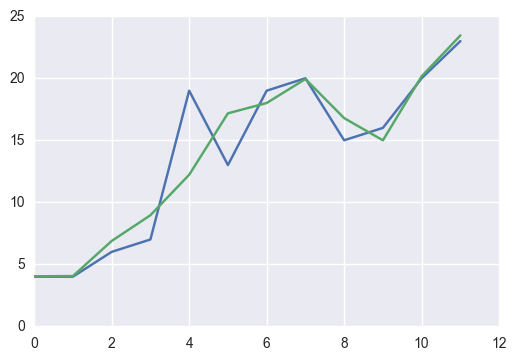

In [401]:
plt.plot(data)
plt.plot(wt(data,data,'db2',2,2,2))

In [405]:
X.iloc[:,:12].values[0]

array([  4.,   4.,   6.,   7.,  19.,  13.,  19.,  20.,  15.,  16.,  20.,
        23.])

In [409]:
X.iloc[:,:12] = np.array([wt(i,_,'db2',2,2,2) for i in X.iloc[:,:12].values])

In [414]:
Xv = df_morning2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]

In [415]:
Xv.iloc[:,:12] = np.array([wt(i,_,'db2',2,2,2) for i in Xv.iloc[:,:12].values])

In [411]:
neigh = KNeighborsRegressor(n_neighbors=9, weights='distance')
neigh.fit(X, y)
# for _ in range(3):
#     y = 0.1*y + 0.9*neigh.predict(X)
#     neigh.fit(X, y)
    

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='distance')

In [419]:
pred_loss(np.vectorize(round)(neigh.predict(Xv)-1), 
          df_morning2_valid.iloc[:,12:24])

0.1164372637452647

In [306]:
pred_loss((neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-1.5), 
          df_morning2_valid.iloc[:,12:24])

0.10849615522538006

In [307]:
from scipy.spatial.distance import wminkowski, minkowski

In [351]:
def weight_func(x):
    if np.partition(x[0], -8)[-8]<20:
        return np.array([[1/i if i<=20 else 0 for i in x[0]]])
    else:
        return np.array([[1/i if i<=np.partition(x[0], -8)[-8] else 0 for i in x[0]]])

In [383]:
k = -0.1

wmink = np.append(np.logspace(k,0,12), np.logspace(k,0,12).mean())

neigh = KNeighborsRegressor(n_neighbors=9, 
                            algorithm='brute',
                            weights=weight_func,
                            metric=lambda a,b: wminkowski(a,b,2,wmink))

neigh.fit(X, y)

KNeighborsRegressor(algorithm='brute', leaf_size=30,
          metric=<function <lambda> at 0x10d399b18>, metric_params=None,
          n_jobs=1, n_neighbors=9, p=2,
          weights=<function weight_func at 0x10db1e1b8>)

In [384]:
pred_loss((neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-1.5), 
          df_morning2_valid.iloc[:,12:24])

0.10826635739487822

In [327]:
weight_result = []
for k in np.linspace(-0.6,0.2,41):

    wmink = np.append(np.logspace(k,0,12), np.logspace(k,0,12).mean())

    neigh = KNeighborsRegressor(n_neighbors=9, 
                                algorithm='brute',
                                weights='distance',
                                metric=lambda a,b: wminkowski(a,b,2,wmink))
    neigh.fit(X, y)

    loss = \
    pred_loss((neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]))-1.5, 
          df_morning2_valid.iloc[:,12:24])
    weight_result.append(([k, loss]))
    

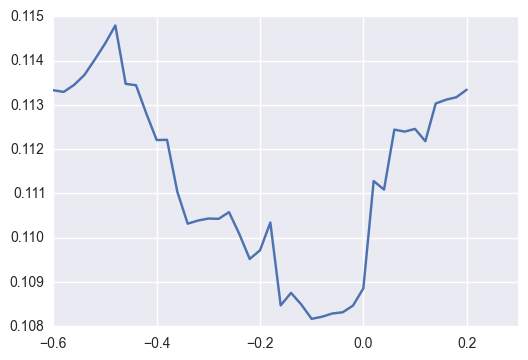

In [328]:
plt.plot([i[0] for i in weight_result], [i[1] for i in weight_result])

In [112]:
neigh_morning = copy.deepcopy(neigh)


In [271]:
X = df_morning2.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]#.values
y = df_morning2.iloc[:,12:24]
X = X.drop([98,145])
y = y.drop([98,145])

k = -0.1

wmink = np.append(np.logspace(k,0,12), np.logspace(k,0,12).mean())

neigh = KNeighborsRegressor(n_neighbors=9, 
                            algorithm='brute',
                            weights='distance',
                            metric=lambda a,b: wminkowski(a,b,2,wmink))

neigh.fit(X, y)

KNeighborsRegressor(algorithm='brute', leaf_size=30,
          metric=<function <lambda> at 0x10d1cc5f0>, metric_params=None,
          n_jobs=1, n_neighbors=9, p=2, weights='distance')

In [272]:
pred_loss((neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-1.5), 
          df_morning2_valid.iloc[:,12:24])

0.036685494697065335

In [273]:
neigh_morning_all = copy.deepcopy(neigh)

In [274]:
neigh_morning_all.predict(df_morning2.loc[98][[0,1,2,3,4,5,6,7,8,9,10,11,-1]])

/Users/yutao/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 29.56452444,  30.77229729,  33.82878291,  32.83611513,
         35.03425183,  38.33526968,  36.48833349,  37.01304935,
         35.96666296,  39.99792797,  36.42325368,  37.5591328 ]])

In [56]:
# neigh = KNeighborsRegressor(n_neighbors=12, 
#                             algorithm='brute',
#                             weights='distance',
#                             #metric=lambda a,b: wminkowski(a,b,2,wmink),
#                             #metric=lambda a, b: minkowski(a,b,2),
#                             metric= adjusted_minkowski
#                            )
# neigh.fit(X, y)
# for _ in range(0):
#     y = 0.1*y + 0.9*neigh.predict(X)
#     neigh.fit(X, y)
    

In [57]:
# X = df_morning2_train.iloc[:,[0,1,2,3,4,5,-6]]#.values
# y = df_morning2_train.iloc[:,6]#.values

In [58]:
# neigh = KNeighborsRegressor(n_neighbors=5)
# neigh.fit(X, y)
# for _ in range(3):
#     y = 0.1*y + 0.9*neigh.predict(X)
#     neigh.fit(X, y)

In [59]:
# pred_loss(np.vectorize(round)(neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-6]])-4), 
#           df_morning2_valid.iloc[:,6])

# Outlier in test data, use some outliers in national days as proxy training data

# Remove outliers

/Users/yutao/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


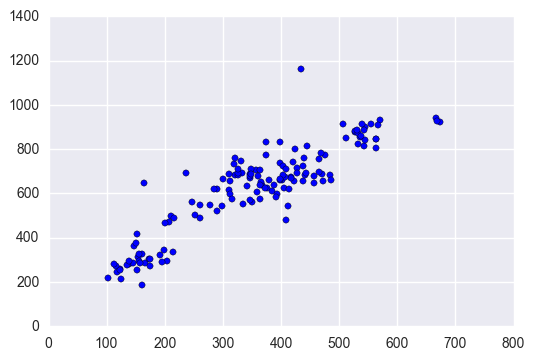

In [60]:
plt.scatter(df_morning2.iloc[:,:12].sum(axis=1), df_morning2.iloc[:,12:24].sum(axis=1))

In [61]:
df_morning2[(df_morning2.iloc[:,:12].sum(axis=1)<200)&(df_morning2.iloc[:,12:24].sum(axis=1)>600)]

0    1     2    3    4    5    6    7     8     9  ...     17    18  \
98  13.0  8.0  13.0  0.0  0.0  0.0  0.0  0.0  10.0  40.0  ...   50.0  55.0   

      19    20    21    22    23  ti          dl  wkwn  
98  53.0  59.0  65.0  58.0  37.0  20  2016-10-15     0  

[1 rows x 27 columns]

In [146]:
df_morning2[(df_morning2.iloc[:,:12].sum(axis=1)<500)&(df_morning2.iloc[:,12:24].sum(axis=1)>1000)]

0     1     2     3     4     5     6     7     8     9  ...      17  \
145  11.0  13.0  22.0  21.0  35.0  31.0  20.0  63.0  46.0  51.0  ...   102.0   

       18    19     20     21    22    23  ti          dl  wkwn  
145  93.0  98.0  114.0  108.0  85.0  89.0  31  2016-09-20    35  

[1 rows x 27 columns]

# Submission (morning)

In [293]:
X = df_morning2.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]#.values
y = df_morning2.iloc[:,12:24]
X = X.drop([98,145])
y = y.drop([98,145])

k = -0.1

wmink = np.append(np.logspace(k,0,12), np.logspace(k,0,12).mean())

neigh_morning_all = KNeighborsRegressor(n_neighbors=9, 
                            algorithm='brute',
                            weights='distance',
                            metric=lambda a,b: wminkowski(a,b,2,wmink))

neigh_morning_all.fit(X, y)

KNeighborsRegressor(algorithm='brute', leaf_size=30,
          metric=<function <lambda> at 0x10d1cc938>, metric_params=None,
          n_jobs=1, n_neighbors=9, p=2, weights='distance')

In [294]:
morn_pred = neigh_morning_all.predict(df_morning_test.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-1.5


In [295]:
morn_pred.sum()

20486.456794542668

In [296]:
daily_mean = df_morning2.mean()[:24]

adjusted19 = np.array(df_morning_test.iloc[19,:12].sum() / daily_mean[:12].sum() * daily_mean[12:24])

In [297]:
morn_pred[19] = adjusted19 - 1.5

In [298]:
morn_pred = \
np.transpose((morn_pred[:,::2]+morn_pred[:,1::2]).reshape(5,7,6), 
             axes=(0,2,1)).reshape(1,-1)[0]

In [299]:
adjusted19

array([ 6.79531385,  6.99880495,  7.15257425,  7.14152496,  7.28608651,
        7.1829598 ,  7.16270277,  7.04392289,  6.69126636,  6.7934723 ,
        6.23456234,  6.09184233])

In [300]:
import pickle

In [301]:
pickle.dump(morn_pred, open('morn_pred1.p', 'wb'))

In [220]:
df_morning2.iloc[:,:12].sum(axis=1).sort_values().iloc[:5]

34    102.0
33    112.0
10    116.0
20    118.0
6     123.0
dtype: float64

In [221]:
df_morning_test.iloc[:,:12].sum(axis=1).sort_values().iloc[:5]

19     47
4     135
2     149
1     154
3     154
dtype: int64

In [77]:
df_morning_test.loc[20]

0                1
1                9
2                6
3                4
4                7
5                7
6               16
7               21
8               19
9               23
10              36
11              22
ti              20
dl      2016-10-31
wkwn            35
Name: 20, dtype: object

In [80]:
df_morning2.iloc[60]

0                0
1                6
2                5
3                4
4                4
5               10
6               14
7               28
8               14
9               23
10              26
11              18
12              20
13              17
14              14
15              16
16              12
17              54
18              48
19              56
20              55
21              45
22              40
23              40
ti              20
dl      2016-09-21
wkwn            35
Name: 74, dtype: object

In [76]:
neigh_morning_all.kneighbors(df_morning_test.loc[20,[0,1,2,3,4,5,6,7,8,9,10,11,'wkwn']])

/Users/yutao/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 16.96821207,  22.06153124,  22.28010959,  24.59949376,
          24.69284053,  24.90583467,  24.91771152,  25.24975704,
          26.44147888]]), array([[60, 21, 28, 14, 25, 22,  4, 67, 16]]))

In [51]:
X = df_morning2_train.iloc[:,[0,1,2,3,4,5,-1]]#.values
y = df_morning2_train.iloc[:,6]#.values

In [52]:
from sklearn import svm

clf = svm.SVR(C=0.1, epsilon=0.1)
clf.fit(X, y) 


SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
pred_loss(np.vectorize(round)(clf.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-6]])-4), 
          df_morning2_valid.iloc[:,6])

ValueError: total size of new array must be unchanged

In [ ]:
clf.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-6]])

In [ ]:
npredm = neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-1]])

In [ ]:
ratio = (df_morning2_train.mean()[6:12])/sum(df_morning2_train.mean()[6:12])

In [ ]:
ratio = np.array(ratio)

In [ ]:
npredm2 = np.array([i.sum()*ratio for i in npredm])

In [ ]:
pred_loss(npredm2, 
          df_morning2_valid.iloc[:,6:12])

In [ ]:
from scipy.spatial.distance import wminkowski, minkowski

In [ ]:
wminkowski([1,2], [3,4], 2, [1,2])

In [ ]:
?KNeighborsRegressor

In [ ]:
def adjusted_minkowski(a, b):
    dist = minkowski(a, b, 2)
    if dist > 1e-2:
        return dist
    return 1000

In [ ]:
X = df_morning2_train.iloc[:,[0,1,2,3,4,5,-1]].values
y = df_morning2_train.iloc[:,6:12].values

#wmink = np.append(np.logspace(0,0,6), 1)

neigh = KNeighborsRegressor(n_neighbors=12, 
                            algorithm='brute',
                            weights='distance',
                            #metric=lambda a,b: wminkowski(a,b,2,wmink),
                            #metric=lambda a, b: minkowski(a,b,2),
                            metric= adjusted_minkowski
                           )
neigh.fit(X, y)


In [54]:
pred_loss(np.vectorize(round)(neigh.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-1]])-4), 
          df_morning2_valid.iloc[:,6:12])

ValueError: query data dimension must match training data dimension

In [55]:
npred = neigh_morning.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-1]])
ntrue = df_morning2_valid.iloc[:,6:12].values


ValueError: query data dimension must match training data dimension

In [56]:
ntruef = ntrue.flatten()
npredf = npred.flatten()

NameError: name 'ntrue' is not defined

In [57]:
((ntruef-npredf)**2/npredf*2/len(ntruef)).sum()

NameError: name 'ntruef' is not defined

In [58]:
# npred = neigh.predict(df_morning2_train.iloc[:,[0,1,2,3,4,5,-1]])
# ntrue = df_morning2_train.iloc[:,6:12].values

In [59]:
loss_ratio = ((ntrue-npred)/npred).flatten()
plt.hist(loss_ratio, bins=18)

NameError: name 'ntrue' is not defined

In [60]:
(loss_ratio>0.4).reshape(-1,6).sum(axis=1)

NameError: name 'loss_ratio' is not defined

In [116]:
df_morning2_valid[(loss_ratio>0.4).reshape(-1,6).sum(axis=1)>0]

0     1     2     3      4     5      6      7      8      9     10  \
179  23.0  41.0  60.0  75.0  101.0  99.0  174.0  122.0  164.0  152.0  113.0   

        11  ti          dl  wkwn  
179  109.0  31  2016-10-24    35

In [117]:
from scipy.stats import norm

In [118]:
norm.fit(loss_ratio, floc=0)

(0, 0.14591701387145453)

In [283]:
df_night2['wkwn'] = ([1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1]+[1,1,1,1,0,0,1])*5
df_night2['wkwn'] *= 34

/Users/MISSZHOU/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/MISSZHOU/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [284]:
date_train = df_night2['dl'].unique()[:-7]
df_night2_train = df_night2[df_night2['dl'].isin(date_train)]
df_night2_valid = df_night2[~df_night2['dl'].isin(date_train)]

In [297]:
X = df_night2_train.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]#.values
y = df_night2_train.iloc[:,12:24]#.values

neigh = KNeighborsRegressor(n_neighbors=11, weights='distance')
neigh.fit(X, y) 
pred_loss((neigh.predict(df_night2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-2.3), 
          df_night2_valid.iloc[:,12:24])

0.15161993438792401

In [254]:
for i in [[i,i+1] for i in [12,14,16,18,20,22]]:
    X = df_night2_train.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]]#.values
    y = df_night2_train.iloc[:,i]#.values

    neigh = KNeighborsRegressor(n_neighbors=10, weights='distance')
    neigh.fit(X, y) 
    print i
    print \
    pred_loss((neigh.predict(df_night2_valid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,-1]])-2.5), 
              df_night2_valid.iloc[:,i])

[12, 13]
0.117153691749
[14, 15]
0.142872125649
[16, 17]
0.159748957693
[18, 19]
0.137629939186
[20, 21]
0.156696298517
[22, 23]
0.214135857653


In [50]:
# X = df_night2_train.iloc[:,[0,1,2,3,4,5,-1]]#.values
# y = df_night2_train.iloc[:,6]#.values

# neigh = KNeighborsRegressor(n_neighbors=12, weights='distance')
# neigh.fit(X, y) 
# pred_loss(np.vectorize(round)(neigh.predict(df_night2_valid.iloc[:,[0,1,2,3,4,5,-1]])*0.97), 
#           df_night2_valid.iloc[:,6])

In [65]:
X = df_night2_train.iloc[:,[0,1,2,3,4,5,-1]]#.values
y = df_night2_train.iloc[:,6:12]#.values

wmink = np.append(np.logspace(0,0,6), 1)

neigh = KNeighborsRegressor(n_neighbors=12, 
                            algorithm='brute',
                            weights=lambda x: 1/x,
                            metric=lambda a,b: wminkowski(a,b,2,wmink))
neigh.fit(X, y)
    

KNeighborsRegressor(algorithm='brute', leaf_size=30,
          metric=<function <lambda> at 0x113403ed8>, metric_params=None,
          n_jobs=1, n_neighbors=12, p=2,
          weights=<function <lambda> at 0x113403a28>)

In [66]:
def night_adjust(x):
    return round(x * (1 - 2/x))

In [76]:
for i in range(2,8):
    print i
    print \
pred_loss((neigh.predict(df_night2_valid.iloc[:,[0,1,2,3,4,5,-1]]))-i, 
          df_night2_valid.iloc[:,6:12])

2
0.163191423059
3
0.15858057775
4
0.155838181015
5
0.15450749045
6
0.154241763586
7
0.155280417312


In [79]:
for i in range(1,8):
    print i
    print \
pred_loss((neigh_morning.predict(df_morning2_valid.iloc[:,[0,1,2,3,4,5,-1]]))-i, 
          df_morning2_valid.iloc[:,6:12])

1
0.133028723982
2
0.132618472208
3
0.133114863353
4
0.13408581566
5
0.135759917829
6
0.138190893417
7
0.14089308215


In [132]:
neigh_night = copy.deepcopy(neigh)

In [133]:
npred = neigh.predict(df_night2_valid.iloc[:,[0,1,2,3,4,5,-1]])
ntrue = df_night2_valid.iloc[:,6:12].values

In [134]:
npredf = npred.flatten()
ntruef = ntrue.flatten()

In [135]:
((ntruef-npredf)**2/npredf*2/len(ntruef)).sum()

4.515412049371311

/Users/yutao/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


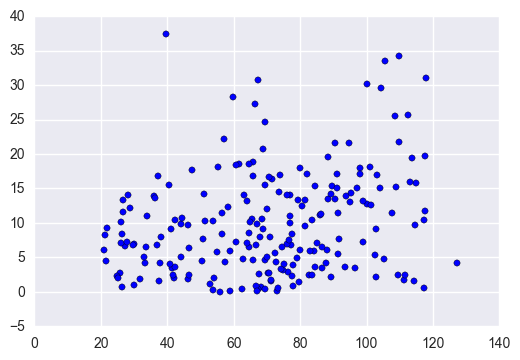

In [136]:
plt.scatter(npred.flatten(), np.abs(ntrue-npred).flatten())

(array([  2.,   5.,  11.,  25.,  38.,  34.,  36.,  24.,  12.,   9.,   7.,
          4.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.50167326, -0.42120683, -0.34074039, -0.26027396, -0.17980752,
        -0.09934109, -0.01887465,  0.06159178,  0.14205822,  0.22252465,
         0.30299109,  0.38345752,  0.46392396,  0.54439039,  0.62485683,
         0.70532326,  0.78578969,  0.86625613,  0.94672256]),
 <a list of 18 Patch objects>)

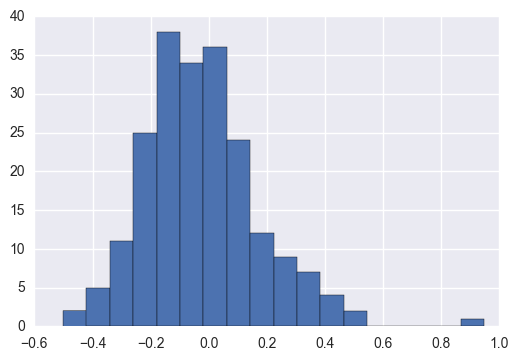

In [137]:
loss_ratio = ((ntrue-npred)/npred).flatten()
plt.hist(loss_ratio, bins=18)

In [138]:
norm.fit(loss_ratio, floc=0)

(0, 0.20113119528615875)

In [144]:
op = []
k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list(0.97*neigh_morning.predict(tvm).T.reshape(1,-1)[0])

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list(0.97*neigh_night.predict(tvm).T.reshape(1,-1)[0])

In [198]:
sample['volume'] = op

sample.to_csv('submission/submission_0503v.csv', index=False)

In [966]:
op = []
k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_morning.predict(tvm)-3).T.reshape(1,-1)[0])

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_night.predict(tvm)-3).T.reshape(1,-1)[0])

In [963]:
sample['volume'] = op

sample.to_csv('submission/submission_0504v.csv', index=False)

In [ ]:
op = []
k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_morning.predict(tvm)-5).T.reshape(1,-1)[0])

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_night.predict(tvm)-5).T.reshape(1,-1)[0])

In [998]:
sample['volume'] = op

sample.to_csv('submission/submission_0506v.csv', index=False)

In [968]:
op = []
k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_morning.predict(tvm)-4).T.reshape(1,-1)[0])

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_night.predict(tvm)-4).T.reshape(1,-1)[0])

In [969]:
sample['volume'] = op

sample.to_csv('submission/submission_0505v.csv', index=False)

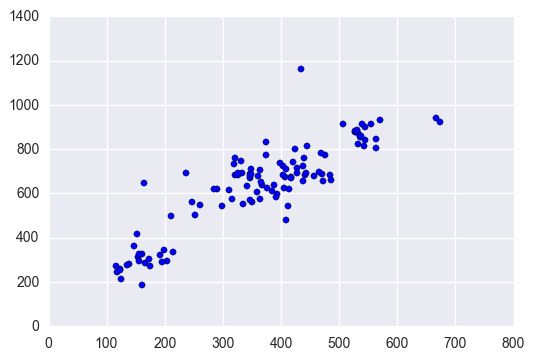

In [1531]:
plt.scatter(df_morning2.iloc[:,:6].sum(axis=1), df_morning2.iloc[:,6:12].sum(axis=1))

In [173]:
df_night2.loc[67]

0               11
1               15
2               10
3               18
4               29
5               76
6               56
7               79
8               69
9               43
10              54
11              52
ti              20
dl      2016-09-28
wkwn            35
Name: 67, dtype: object

In [163]:
df_night2.iloc[:,:6].sum(axis=1).sort_values()

67      159.0
20      252.0
21      253.0
19      255.0
24      266.0
23      267.0
7       273.0
22      278.0
2       280.0
28      289.0
8       289.0
0       291.0
3       318.0
10      328.0
26      340.0
1       361.0
5       372.0
6       384.0
77      386.0
4       397.0
78      399.0
27      404.0
25      408.0
59      422.0
79      430.0
65      431.0
81      432.0
66      444.0
86      445.0
61      446.0
        ...  
110     656.0
108     657.0
97      658.0
11      658.0
122     658.0
33      660.0
109     664.0
89      667.0
96      669.0
140     670.0
121     673.0
120     683.0
94      686.0
56      687.0
87      691.0
95      691.0
54      693.0
107     696.0
90      725.0
111     729.0
88      744.0
114     760.0
113     781.0
143     784.0
93      806.0
69      826.0
112     837.0
92      847.0
91      934.0
98     1162.0
dtype: float64

In [162]:
(116+118+123+123+124)/5

120.8

In [171]:
test_vol_group_count.loc[3].loc[1].reshape(-1,6)[1::2].sum(axis=1)

array([514, 532, 543, 583, 505, 633, 515])

In [1294]:
op = []
k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    if (i, j) != (1, 0):
        op += list((neigh_morning.predict(tvm)-4).T.reshape(1,-1)[0])
    else:
        predtmp = neigh_morning.predict(tvm)
        predtmp[4] = predtmp[4] * 112 / 125.6
        predtmp[5] = predtmp[5] * 102 / 125.6
        op += list((predtmp-4).T.reshape(1,-1)[0])

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_night.predict(tvm)-4).T.reshape(1,-1)[0])

In [1295]:
sample['volume'] = op

sample.to_csv('submission/submission_0516v.csv', index=False)

In [262]:
op = []

k = 35

for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    if (i, j) != (1, 0):
        op += list((neigh_morning.predict(tvm)-4).T.reshape(1,-1)[0])
    else:
        predtmp = neigh_morning.predict(tvm)
        predtmp[4] = predtmp[4] * 112 / 120.8
        predtmp[5] = predtmp[5] * 102 / 120.8
        op += list((predtmp-4).T.reshape(1,-1)[0])

k = 55      
        
for i, j in [(1,0), (1,1), (2,0), (3,0), (3,1)]:
    tvm = test_vol_group_count.loc[i].loc[j].reshape(-1,6)[1::2]
    tvm = np.concatenate([tvm, [[k],[k],[k],[k],[0],[0],[k]]], axis=1)
    op += list((neigh_night.predict(tvm)-4).T.reshape(1,-1)[0])

In [263]:
sample['volume'] = op

sample.to_csv('submission/submission_0523v.csv', index=False)

In [665]:
df_morning2_valid.describe()

0          1          2           3           4           5  \
count  35.000000  35.000000  35.000000   35.000000   35.000000   35.000000   
mean   24.828571  36.657143  51.285714   67.800000   82.600000   92.542857   
std    10.664636  13.588366  23.447779   31.796966   33.962956   37.016962   
min     6.000000   7.000000   0.000000    0.000000   27.000000   30.000000   
25%    17.000000  29.000000  35.000000   40.000000   51.500000   61.500000   
50%    24.000000  39.000000  54.000000   72.000000   79.000000   92.000000   
75%    32.500000  45.000000  66.500000   91.000000  108.000000  119.000000   
max    45.000000  68.000000  95.000000  145.000000  162.000000  165.000000   

                6           7           8           9          10          11  \
count   35.000000   35.000000   35.000000   35.000000   35.000000   35.000000   
mean   100.714286  106.628571  110.285714  107.485714  100.542857   93.142857   
std     39.767391   36.972236   39.023049   33.110662   28.289827   29.550697   
min     29.000000   44.000000   35.000000   43.000000   46.000000   34.000000   
25%     76.500000   80.000000   92.500000   97.500000   93.000000   74.500000   
50%    107.000000  111.000000  121.000000  112.000000  107.000000   98.000000   
75%    126.000000  132.500000  134.000000  127.000000  116.500000  115.500000   
max    175.000000  182.000000  180.000000  161.000000  150.000000  152.000000   

            wkwn  
count  35.000000  
mean   25.000000  
std    16.042224  
min     0.000000  
25%     0.000000  
50%    35.000000  
75%    35.000000  
max    35.000000

In [664]:
df_night2_valid.describe()

0           1           2           3           4           5  \
count   35.000000   35.000000   35.000000   35.000000   35.000000   35.000000   
mean    89.771429   92.542857   88.971429   92.857143   93.628571   91.314286   
std     28.768943   27.110170   26.510249   28.370597   25.323885   27.138828   
min     37.000000   43.000000   33.000000   41.000000   42.000000   42.000000   
25%     74.000000   78.500000   74.000000   70.000000   79.000000   73.000000   
50%     93.000000   92.000000   89.000000   90.000000   94.000000   91.000000   
75%    108.500000  107.500000  107.000000  111.500000  114.000000  105.000000   
max    140.000000  159.000000  137.000000  144.000000  135.000000  149.000000   

                6           7           8           9          10         11  \
count   35.000000   35.000000   35.000000   35.000000   35.000000  35.000000   
mean    90.628571   91.228571   86.371429   67.085714   66.085714  56.114286   
std     27.041456   32.079025   34.166621   25.509366   22.553689  20.619482   
min     39.000000   26.000000   24.000000   22.000000   24.000000  14.000000   
25%     76.000000   73.000000   66.000000   47.000000   53.500000  40.500000   
50%     89.000000   93.000000   90.000000   71.000000   70.000000  57.000000   
75%    111.500000  120.000000  112.500000   88.000000   83.500000  72.000000   
max    146.000000  139.000000  135.000000  125.000000  109.000000  99.000000   

            wkwn  
count  35.000000  
mean   25.000000  
std    16.042224  
min     0.000000  
25%     0.000000  
50%    35.000000  
75%    35.000000  
max    35.000000

In [986]:
from sklearn.decomposition import PCA

In [991]:
pca = PCA()
pca.fit(df_night2.iloc[:,:6])

PCA(copy=True, n_components=None, whiten=False)

In [992]:
pca.components_

array([[ 0.37872265,  0.3976921 ,  0.40932576,  0.43316427,  0.3947647 ,
         0.43288812],
       [ 0.5479476 ,  0.25093885,  0.05990307,  0.17947525, -0.2235362 ,
        -0.74230381],
       [-0.45182228, -0.38759207,  0.34969856,  0.56851206,  0.2467298 ,
        -0.37317338],
       [ 0.40910238, -0.53998244,  0.40779711, -0.49507521,  0.35249739,
        -0.07349724],
       [-0.17394916,  0.10099201,  0.71122249, -0.14620048, -0.64603849,
         0.12232974],
       [ 0.39313629, -0.57171903, -0.18557761,  0.43643709, -0.43783177,
         0.31932453]])

In [996]:
dfnpca = pca.transform(df_night2.iloc[:,:6])

In [70]:
training_weather = pd.read_csv('weather (table 7)_training_update.csv')

In [80]:
training_weather['datetime'] = \
    [datetime(int(i[:4]), int(i[5:7]), int(i[8:10]), j) for i, j in \
         zip(training_weather['date'], training_weather['hour'])]

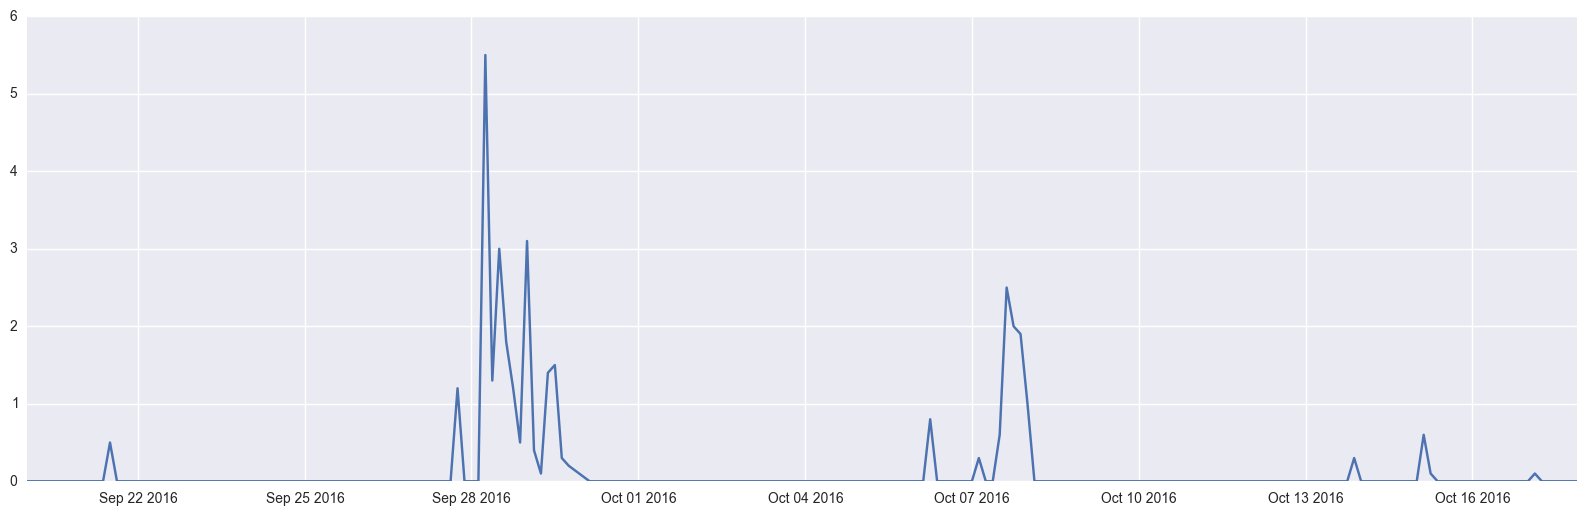

In [94]:
wt = training_weather.iloc[648:]

plt.figure(figsize=(20,6))
plt.plot(wt['datetime'], wt['precipitation'])

In [139]:
X1 = np.array([[1,2],[3,4],[5,3],[2,3]])

In [140]:
X2 = np.array([[1,7],[5,5],[4,3]])

In [141]:
m = np.array([1,2])
n = np.array([2,7])

In [151]:
((m-n)**2).sum()

26

In [145]:
fsf=None

In [272]:
def f(y=5, x):
    return x*y

SyntaxError: non-default argument follows default argument (<ipython-input-272-995ee8d9c80a>, line 1)

In [271]:
f(2)

NameError: global name 'x' is not defined

# Self-written KNN

In [239]:
class KNeighborsRegressor_M():
    def __init__(self, n_neighbors=5, weights='uniform', 
                 distance_weights=None):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.distance_weights = distance_weights

        
    def fit(self, X, y):
        self._fit_X = X
        self._fit_y = y
    
    @staticmethod
    def distance_metric(m, n, dw):
        m = np.array(m)
        n = np.array(n)
        if dw != None:
            try:
                return np.sqrt(((m-n)**2*np.array(dw)).sum())
            except:
                raise ValueError('Check distance_weights')
        return np.sqrt(((m-n)**2).sum())
    
    def distance_matrix(self, X1, X2):
        dmatrix = \
            [[KNeighborsRegressor_M.distance_metric(
                        i, j, self.distance_weights) 
              for i in X1] for j in X2]
        dmatrix = np.array(dmatrix)
        return dmatrix
    
    def predict(self, X):
        _dmatrix = self.distance_matrix(self._fit_X, X)
        nn = min(self.n_neighbors, self._fit_X.shape[0])
        nn_dist_matrix = np.array([np.partition(i, 2)[:2] for i in _dmatrix])
        nn_arg_matrix = np.array([np.argpartition(i, 2)[:2] for i in _dmatrix])
        
        
        return None
    
    
    

In [244]:
dm = KNeighborsRegressor_M(distance_weights=None).distance_matrix(X1, X2)
dm

array([[ 5.        ,  3.60555128,  5.65685425,  4.12310563],
       [ 5.        ,  2.23606798,  2.        ,  3.60555128],
       [ 3.16227766,  1.41421356,  1.        ,  2.        ]])

In [235]:
np.array([np.partition(i, 2)[:2] for i in dm])

array([[ 3.60555128,  4.12310563],
       [ 2.        ,  2.23606798],
       [ 1.        ,  1.41421356]])

In [234]:
[np.argpartition(i, 2)[:2] for i in dm]

[array([1, 3]), array([2, 1]), array([2, 1])]

In [229]:
np.argpartition(test, 4)[:4]

array([9, 1, 6, 2])

In [230]:
np.partition(test, 4)[:4]

array([0, 1, 1, 3])

In [231]:
?np.partition